In [13]:
import json
import time
from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import redis
from redis.commands.search.field import TextField, NumericField, TagField, VectorField
from redis.commands.search.indexDefinition import IndexDefinition, IndexType
from redis.commands.search.query import NumericFilter, Query

import requests
import glob
from PIL import Image
from io import BytesIO
from redis_vectorize.embed import TextVectorizingModel, ImageVectorizingModel


In [14]:
text_vectorizer = TextVectorizingModel(filename="models/bge.quant.onnx")
image_vectorizer = ImageVectorizingModel(filename="./models/mobileclip_s0.pt")


In [37]:
def get(url, cache='data/images'):
    filename=url.split("/")[-1]
    if filename in list(map(lambda x: x.split('/')[-1], glob.glob(f'{cache}/*'))):
        im = Image.open(f'{cache}/{filename}')
    else:
        response = requests.get(url)
        if response.status_code != 400:
            im=Image.open(BytesIO(response.content))
            im.save(f'{cache}/{filename}')
    return im

In [181]:
cache

'data/images'

In [191]:
df = pd.read_csv("./products_with_categories.csv")
#df = df.drop(['Unnamed: 0'], axis=1)#,'asin', 'stars', 'listPrice', 'reviews', 'productURL', 'isBestSeller', 'boughtInLastMonth'], axis=1)
N = len(df)
df.head()

#df=df.drop('id', axis=1)

,title,img,price,category
0,Eureka NEC185 Cordless Stick Vacuum Cleaner Co...,716X0z1KILL._AC_UL320_.jpg,152.99,Vacuum Cleaners & Floor Care
1,Hoover Power Scrub Deluxe Carpet Cleaner Machi...,71zMtxB9xTL._AC_UL320_.jpg,181.36,Vacuum Cleaners & Floor Care
2,Prolux Core Floor Buffer - Heavy Duty Single P...,71+t-F84jDS._AC_UL320_.jpg,499.99,Vacuum Cleaners & Floor Care
3,Shark NV356E Navigator Lift-Away Professional ...,61OsbGCnrqL._AC_UL320_.jpg,199.99,Vacuum Cleaners & Floor Care
4,Tineco iFLOOR 3 Breeze Complete Wet Dry Vacuum...,71rvT22VH3L._AC_UL320_.jpg,279.99,Vacuum Cleaners & Floor Care


In [129]:
client= redis.Redis(host='localhost', port=6379)
pipeline = client.pipeline()

for i in trange(N):
    row = df.iloc[i]
    redis_key = f"product:{i:07}"
    im=get(f"{cache}/{row['img']}")
    image_embedding = image_vectorizer.vectorize(im)[0].tolist()
    text_embedding = text_vectorizer.vectorize(row['title'])[0].tolist()

    to_add = row.to_dict()
    to_add['text_embedding'] = []
    to_add['image_embedding'] = []
    
    pipeline.json().set(redis_key, "$", to_add)
    pipeline.json().set(redis_key, "$.text_embedding", text_embedding)
    pipeline.json().set(redis_key, "$.image_embedding", image_embedding)

res = pipeline.execute()

  0%|          | 0/4439 [00:00<?, ?it/s]/Users/nikita/venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|██████████| 4439/4439 [25:14<00:00,  2.93it/s]


In [130]:
client.json().get(redis_key)

{'title': 'Tubing Bender Kit with Reverse Bend 1/4"-7/8" HVAC Ratchet Copper Pipe Bender Tool Set 90° Bend with 7 Dies for Refrigerator Air Conditioner Repair',
 'img': '71KUWoSRW0L._AC_UL320_.jpg',
 'price': 159.88,
 'category': 'Industrial Power & Hand Tools',
 'text_embedding': [-0.07189702242612839,
  -0.01723437011241913,
  -0.05271080136299133,
  0.05155779421329498,
  0.008572828024625778,
  -0.02764253132045269,
  0.006399879232048988,
  0.03096863254904747,
  -0.02027292177081108,
  -0.01996122300624847,
  -0.025096403434872627,
  -0.022140592336654663,
  -0.022113358601927757,
  0.008490446954965591,
  -0.03582801669836044,
  -0.06440628319978714,
  -0.01250985451042652,
  -0.00045193335972726345,
  0.05995435640215874,
  -0.06161179766058922,
  0.005901490803807974,
  -0.013544810004532335,
  -0.0012637466425076127,
  -0.02314501628279686,
  0.05239515006542206,
  0.029904237017035484,
  -0.07209651172161102,
  -0.030791403725743297,
  0.06882677227258682,
  -0.0003808181791

In [131]:
schema = (
    TextField("$.title", no_stem=True, as_name="title"),
    TextField("$.img", no_stem=True, as_name="path to image"),
    NumericField("$.price", as_name="example price"),
    TextField("$.category"),
    VectorField(
        "$.text_embedding",
        "FLAT",
        {
            "TYPE": "FLOAT32",
            "DIM": 1024,
            "DISTANCE_METRIC": "L2",
        },
        as_name="text_vector",
    ),
    VectorField(
        "$.image_embedding",
        "FLAT",
        {
            "TYPE": "FLOAT32",
            "DIM": 512,
            "DISTANCE_METRIC": "L2",
        },
        as_name="image_vector",
    )
)

definition = IndexDefinition(prefix=["product:"], index_type=IndexType.JSON)
res = client.ft("idx:product_vss").create_index(
    fields=schema, definition=definition
)

In [132]:
info = client.ft("idx:product_vss").info()
num_docs = info["num_docs"]
indexing_failures = info["hash_indexing_failures"]

In [146]:
assert indexing_failures == '0'
print(f"{num_docs} documents indexed with {indexing_failures} failures")

4439 documents indexed with 0 failures


In [ ]:
with open("pics/dewalt.jpeg")

In [186]:
queries = text_vectorizer.vectorize("Хочу полетать на дроне")
query = (
    Query('(*)=>[KNN 3 @text_vector $query_vector AS vector_score]')
     .sort_by('vector_score')
     .return_fields('vector_score', 'title', 'price', 'img', 'category')
     .dialect(2)
)
print(client.ft("idx:product_vss").search(query, { 
    'query_vector': queries.tobytes() 
    }).docs


queries = image_vectorizer.vectorize(Image.open("pics/dewalt.jpeg"))

query = (
    Query('(*)=>[KNN 3 @image_vector $query_vector AS vector_score]')
     .sort_by('vector_score')
     .return_fields('vector_score', 'title', 'price', 'img', 'category')
     .dialect(2)
)
client.ft("idx:product_vss").search(query, { 
    'query_vector': queries.tobytes() 
    }).docs

[Document {'id': 'product:0002304', 'payload': None, 'vector_score': '0.796755254269', 'title': 'T210 GPS Drone with Camera 4K for Adults,RC Quadcopter with 3-Axis Gimbal,Circle Fly,30 Mins Flight Time,Less than 249g Drone Perfect for Beginners'},
 Document {'id': 'product:0002393', 'payload': None, 'vector_score': '0.799230277538', 'title': '012S Drones with Camera for Adults 4K,60 Mins Long Flight Time,GPS 5G FPV Quadcopter for Beginners with Optical Flow Positioning,Auto Return Home,Follow Me,Waypoint Flight,Brushless Motor'},
 Document {'id': 'product:0004194', 'payload': None, 'vector_score': '0.803587138653', 'title': 'Drones with Camera for Adults 4K: Designed for Beginners, Ultra-Stable Flight, Dual Batteries, Easy-to-Use GPS, Real-Time Transmission, and 2 Sets of Replacement Blades'}]

In [189]:
queries = text_vectorizer.vectorize("Хочу полетать на дроне")

query = (
    Query('(*)=>[KNN 3 @text_vector $query_vector AS vector_score]')
     .sort_by('vector_score')
     .return_fields('vector_score', 'title', 'price', 'img', 'category')
     .dialect(2)
)
print(client.ft("idx:product_vss").search(query, { 
    'query_vector': queries.tobytes() 
    }).docs)

queries = image_vectorizer.vectorize(Image.open("pics/dewalt.jpeg"))

query = (
    Query('(*)=>[KNN 3 @image_vector $query_vector AS vector_score]')
     .sort_by('vector_score')
     .return_fields('vector_score', 'title', 'price', 'img', 'category')
     .dialect(2)
)

print(client.ft("idx:product_vss").search(query, { 
    'query_vector': queries.tobytes() 
    }).docs)

[Document {'id': 'product:0002304', 'payload': None, 'vector_score': '0.796755254269', 'title': 'T210 GPS Drone with Camera 4K for Adults,RC Quadcopter with 3-Axis Gimbal,Circle Fly,30 Mins Flight Time,Less than 249g Drone Perfect for Beginners'}, Document {'id': 'product:0002393', 'payload': None, 'vector_score': '0.799230277538', 'title': '012S Drones with Camera for Adults 4K,60 Mins Long Flight Time,GPS 5G FPV Quadcopter for Beginners with Optical Flow Positioning,Auto Return Home,Follow Me,Waypoint Flight,Brushless Motor'}, Document {'id': 'product:0004194', 'payload': None, 'vector_score': '0.803587138653', 'title': 'Drones with Camera for Adults 4K: Designed for Beginners, Ultra-Stable Flight, Dual Batteries, Easy-to-Use GPS, Real-Time Transmission, and 2 Sets of Replacement Blades'}]


/Users/nikita/venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[Document {'id': 'product:0001408', 'payload': None, 'vector_score': '0.412525504827', 'title': 'DEWALT 20V MAX* XR Drywall Screw Gun Kit, Brushless (DCF620D2)'}, Document {'id': 'product:0000921', 'payload': None, 'vector_score': '0.464602738619', 'title': 'DEWALT 20V MAX* Finish Nailer, Angled, 16GA, Tool Only (DCN660B)'}, Document {'id': 'product:0000905', 'payload': None, 'vector_score': '0.482926130295', 'title': 'DEWALT 20V Max Drywall Screwgun, Tool Only (DCF630B)'}]


In [168]:
client.ft("idx:product_vss").search(query, { 
    'query_vector': queries.tobytes() 
    }).docs


[Document {'id': 'product:0003122', 'payload': None, 'vector_score': '0.739481985569', 'title': "UNP Tents 6 Person Waterproof Windproof Easy Setup,Double Layer Family Camping Tent with 1 Mesh Door & 5 Large Mesh Windows -10'X9'X78in(H)"},
 Document {'id': 'product:0000711', 'payload': None, 'vector_score': '0.755394756794', 'title': "TIMBER RIDGE 5 Person SUV Tent with Movie Screen Weather Resistant Portable for Car SUV Van Camping, Includes Rainfly and Storage Bag, 10' W X 8' L X 7.6' H Khaki"},
 Document {'id': 'product:0003152', 'payload': None, 'vector_score': '0.878926634789', 'title': 'CAMPROS CP Tent 6/8 Person Camping Tents, Weatherproof Family Dome Tent with Rainfly, Large Mesh Windows, Wider Door, Easy Setup, Portable with Carry Bag'}]

In [169]:
client.json().get('product:0000711')

#Image.open("data/images/61FNS+aLPHL._AC_UL320_.jpg")

{'title': "TIMBER RIDGE 5 Person SUV Tent with Movie Screen Weather Resistant Portable for Car SUV Van Camping, Includes Rainfly and Storage Bag, 10' W X 8' L X 7.6' H Khaki",
 'img': '61FNS+aLPHL._AC_UL320_.jpg',
 'price': 219.99,
 'category': 'Automotive Exterior Accessories',
 'text_embedding': [-0.001502271043136716,
  -0.033131130039691925,
  -0.039368320256471634,
  0.000668854161631316,
  -0.025764841586351395,
  -0.04114542528986931,
  -0.011231310665607452,
  0.013540555723011494,
  -0.0030569075606763363,
  -0.01974157989025116,
  0.0398581363260746,
  0.02711769938468933,
  -0.06190193444490433,
  0.02504643052816391,
  -0.004563687369227409,
  -0.019714530557394028,
  -0.0035948690492659807,
  0.001620485563762486,
  0.03008115850389004,
  -0.05886178836226463,
  -0.0045072040520608425,
  -0.032158203423023224,
  -0.03129073604941368,
  0.011476942338049412,
  0.03770768269896507,
  0.00768777821213007,
  0.010136528871953487,
  -0.0011234052944928408,
  0.04479473829269409

In [178]:
queries = text_vectorizer.vectorize("Нужен трипод для камеры")

query = (
    Query('(*)=>[KNN 3 @text_vector $query_vector AS vector_score]')
     .sort_by('vector_score')
     .return_fields('vector_score', 'title', 'price', 'img', 'category')
     .dialect(2)
)

In [179]:
client.ft("idx:product_vss").search(query, { 
    'query_vector': queries.tobytes() 
    }).docs


[Document {'id': 'product:0002527', 'payload': None, 'vector_score': '0.681445002556', 'title': 'Fluid Head Tripod, COMAN Video Camera Tripod Monopod Aluminium Alloy 70.8 inch for Canon Nikon Sony DSLR Camera'},
 Document {'id': 'product:0001824', 'payload': None, 'vector_score': '0.682996451855', 'title': '72" Heavy Duty Tripod for Camera, Professional Fluid Head Video Tripod, 33LB Load Flat Bowl Convert, Aluminum Twin Tube, Mid-Level Spreader, QR Plate for Nikon Canon DSLR Camcorder Camera'},
 Document {'id': 'product:0001612', 'payload': None, 'vector_score': '0.691522717476', 'title': 'Video Tripod, COMAN KX3636 74 inch Professional Heavy Duty Aluminum Tripod with Quick Release Plate and 360 Degree Fluid Head for DSLR, Camcorder, Cameras Max Load:17.6lbs/8Kg'}]

In [176]:
client.json().get('product:0001285')

{'title': 'GEARWRENCH 83 Pc. 1/4, 3/8", 1/2" 90-Tooth SAE/Metric Mechanics Tool Set with EVA Foam Tray - 86529',
 'img': '81TumlXQPrL._AC_UL320_.jpg',
 'price': 244.99,
 'category': 'Industrial Power & Hand Tools',
 'text_embedding': [-0.022531740367412567,
  -0.019209422171115875,
  -0.03832724690437317,
  -0.021652232855558395,
  0.004511806648224592,
  -0.05006651952862739,
  0.014405902475118635,
  -0.0025049354881048203,
  -0.04142896458506584,
  0.03579767420887947,
  0.04467904940247536,
  0.03552645072340965,
  0.012679314240813255,
  0.005910000763833523,
  -0.011525699868798256,
  -0.04003031179308891,
  -0.037800684571266174,
  -0.0011480203829705715,
  0.04966987669467926,
  -0.03686098009347915,
  -0.007337328046560288,
  0.032257914543151855,
  0.0017099576070904732,
  -0.02024792693555355,
  0.058563005179166794,
  0.0202543493360281,
  -0.017522413283586502,
  -0.025326231494545937,
  0.01864331401884556,
  -0.0018505053594708445,
  -0.011807293631136416,
  0.0038819755

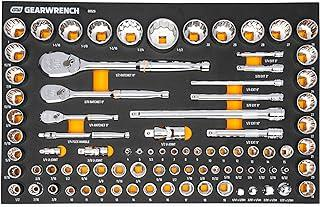

In [177]:
Image.open("data/images/81TumlXQPrL._AC_UL320_.jpg")